# How to build a QAOA ansatz with SWAP strategies

Here, we show how to route a QAOA cost operator, built from commuting two-qubit gates, with a predetermined SWAP strategy. A SWAP strategy is a list of layers of SWAP gates. All the SWAP gates in a layer can be executed in parallel on the hardware coupling map. A SWAP strategy reaches full connectivity if we can implement any two-qubit gate after all of its SWAP layers have been applied.

First, for the sake of simplicity, we import a pre-computed list of two-qubit Z-Paulis from a json file. These Pauli operators define the cost Hamiltonian in a typical QAOA implementation. They are saved in text format.

In [1]:
import json

graph_file = "data/graph_2layers_0seed.json"
data = json.load(open(graph_file, "r"))

local_correlators = data["paulis"]
print(local_correlators)

[['IIIIIZZIII', 1.0], ['IIIIIIZIZI', 1.0], ['IIIIIIZIIZ', 1.0], ['ZIIIIZIIII', 1.0], ['IIIIZZIIII', 1.0], ['IIZIIIIZII', 1.0], ['IZZIIIIIII', 1.0], ['IIZZIIIIII', 1.0], ['IIIIIIIZZI', 1.0], ['IIIIZIIZII', 1.0], ['IIIIZIIIIZ', 1.0], ['IIIIIIIIZZ', 1.0], ['ZZIIIIIIII', 1.0], ['IZIZIIIIII', 1.0], ['ZIIZIIIIII', 1.0]]


This list of Paulis can be used to build a sparse Pauli operator.

In [2]:
from qiskit.quantum_info import SparsePauliOp

cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIIIIZZIII', 'IIIIIIZIZI', 'IIIIIIZIIZ', 'ZIIIIZIIII', 'IIIIZZIIII', 'IIZIIIIZII', 'IZZIIIIIII', 'IIZZIIIIII', 'IIIIIIIZZI', 'IIIIZIIZII', 'IIIIZIIIIZ', 'IIIIIIIIZZ', 'ZZIIIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## 1. Build a circuit for the cost operator Hamiltonian

The QAOA ansatz is composed of a series of alternating layers of cost operator unitary and mixer unitary blocks. Typically, the cost operator unitary is a network of $R_{ZZ}$ gates and the mixer unitary is made of one-local terms. Since such mixer unitaries are trvial to route we focus on the cost operator unitary. We thus create this isolated block for the cost operator we previously loaded using the `annotated_qaoa_ansatz` function. We input an empty `initial_state` and `mixer_operator` fields to make sure we build an isolated cost operator unitary.

In [3]:
from qiskit import QuantumCircuit
from qopt_best_practices.circuit_library import annotated_qaoa_ansatz

dummy_mixer_operator = SparsePauliOp.from_list([("I" * cost_operator.num_qubits, 1)])  # An empty mixer

cost_layer = annotated_qaoa_ansatz(
    cost_operator,
    reps=1,
    initial_state=QuantumCircuit(cost_operator.num_qubits),  # An empty initial state
    mixer_operator=dummy_mixer_operator,
    name="QAOA cost block",
)

As we can now see, the cost operator unitary is built from a network of $R_{ZZ}$ gates given by the Z-Pauli terms that we loaded. If we decompose it again, we will see that these $R_{ZZ}$ gates are built by combining $R_Z$ and CNOT gates.

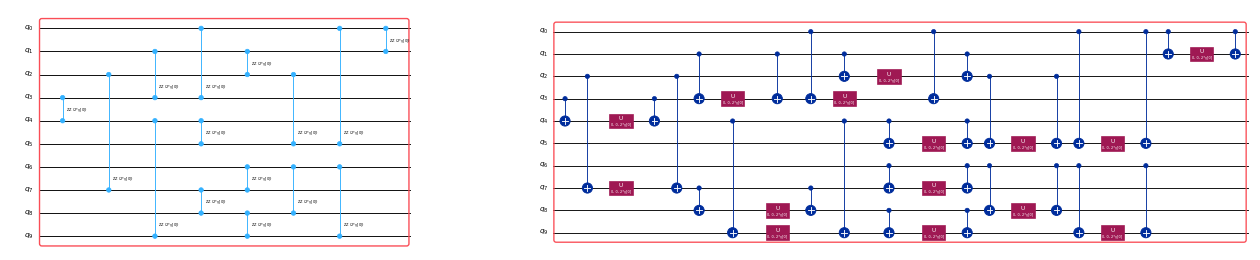

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.8]})

cost_layer.draw("mpl", ax=axs[0])
cost_layer.decompose(reps=3).draw("mpl", ax=axs[1], fold=False)

## 2. Apply SWAP strategies

Here, we define a SWAP strategy on ten qubits with a line connectivity.

In [5]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

swap_strategy = SwapStrategy.from_line([i for i in range(cost_operator.num_qubits)])

If we print the SWAP strategy we see that it is made of two alternating layers of SWAP gates.

In [6]:
print(swap_strategy)

SwapStrategy with swap layers:
((0, 1), (2, 3), (4, 5), (6, 7), (8, 9)),
((1, 2), (3, 4), (5, 6), (7, 8)),
((0, 1), (2, 3), (4, 5), (6, 7), (8, 9)),
((1, 2), (3, 4), (5, 6), (7, 8)),
((0, 1), (2, 3), (4, 5), (6, 7), (8, 9)),
((1, 2), (3, 4), (5, 6), (7, 8)),
((0, 1), (2, 3), (4, 5), (6, 7), (8, 9)),
((1, 2), (3, 4), (5, 6), (7, 8)),
on [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [9, 8]] coupling map.


Now, we define a Qiskit transpiler pass manager to route the cost layer with the swap strategy that we defined above. In addition, we will show how CNOT gates in conescutive $R_{ZZ}$ and CNOT gates simplify.

In [7]:
from qiskit.transpiler import PassManager
from qopt_best_practices.transpilation.annotated_transpilation_passes import AnnotatedPrepareCostLayer, AnnotatedCommuting2qGateRouter, SynthesizeAndSimplifyCostLayer, UnrollBoxes

In [8]:
# Let's route the QAOA circuit to a line of qubits using the swap strategy.
pm1 = PassManager([AnnotatedPrepareCostLayer(), AnnotatedCommuting2qGateRouter(swap_strategy)])
qc1 = pm1.run(cost_layer)

# Let's synthesize the circuit into Rzs and CNOTs and cancel any double CNOTs that compose to the identity.
pm2 = PassManager([SynthesizeAndSimplifyCostLayer(basis_gates=["x", "cx", "sx", "rz", "id"]), UnrollBoxes()])
qc2 = pm2.run(qc1)

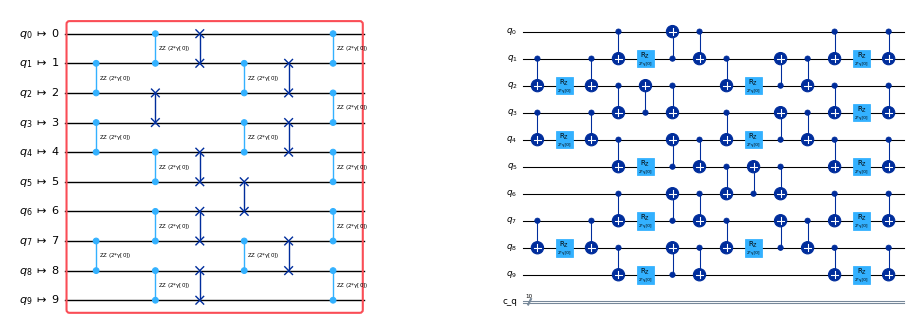

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1]})

qc1.draw("mpl", ax=axs[0])
qc2.draw("mpl", ax=axs[1])

## 3. Edge coloring

The `AnnotatedCommuting2qGateRouter` allows us to specify an edge coloring of the coupling map. This is an assigment of each edge in the coupling map to a color such that edges that share a node all have different colors. This argument defines the order in which $R_{ZZ}$ gates are applied on hardware native edges. For example, if we need to implent the $R_{ZZ}$ gates on edges `(0, 1)` and `(1, 2)` we can chose which one to apply first. To see the impact of the edge coloring we define two of them.

In [10]:
edge_coloring_a = {(idx, idx + 1): (idx) % 2 for idx in range(cost_operator.num_qubits)}
edge_coloring_b = {(idx, idx + 1): (idx + 1) % 2 for idx in range(cost_operator.num_qubits)}

We can now remove the measurements we previously introduced to keep up with the permutations.

In [11]:
pm_a = PassManager([AnnotatedPrepareCostLayer(), AnnotatedCommuting2qGateRouter(swap_strategy, edge_coloring_a)])
pm_b = PassManager([AnnotatedPrepareCostLayer(), AnnotatedCommuting2qGateRouter(swap_strategy, edge_coloring_b)])

In the figures below, we see that edge coloring `edge_coloring_b` is advantageous as it allows for a greater number of CNOT gate simplifications by aligning $R_{ZZ}$ gates with SWAP gates.

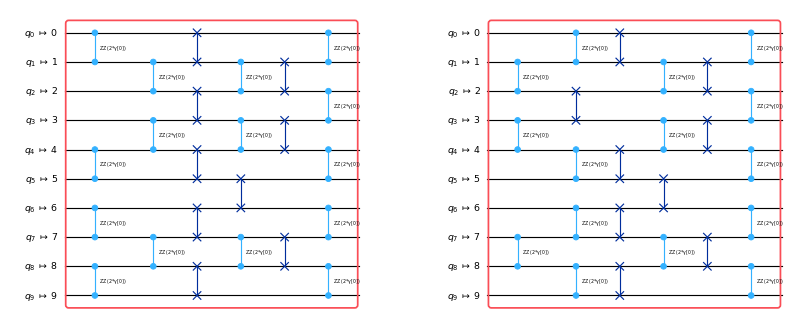

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

pm_a.run(cost_layer).draw("mpl", ax=axs[0])
pm_b.run(cost_layer).draw("mpl", ax=axs[1])